In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:55:29) [Clang 17.0.6 ]
PyTorch version 2.4.1.post102
Torchvision version 0.19.1a0
Numpy version 2.1.2
Pandas version 2.2.3


In [2]:
import os, glob, shutil
from scripts.transfer_files import transfer_random_files
from scripts.move_files import move_files_validation

In [3]:
#### 

In [3]:
classes = ['Fast', 'Koi', 'Slow']
dirs = ['Training', 'Validation']

In [4]:
training_validation_dirs = [i+'/'+j for i in dirs for j in classes]

In [5]:
training_validation_dirs

['Training/Fast',
 'Training/Koi',
 'Training/Slow',
 'Validation/Fast',
 'Validation/Koi',
 'Validation/Slow']

In [6]:
[os.makedirs(k, exist_ok=True) for k in training_validation_dirs]

[None, None, None, None, None, None]

### Transfering files to Training directory and then to Validation directory

In [7]:
# transfer_random_files(source_dir='all_data/Fast', destination_dir=training_validation_dirs[0], n=250)
# transfer_random_files(source_dir='all_data/Koi', destination_dir=training_validation_dirs[1], n=250)
# transfer_random_files(source_dir='all_data/Slow', destination_dir=training_validation_dirs[2], n=250)

In [8]:
# move_files_validation(category=classes[0], path1 = f'all_data/{classes[0]}/', path2 = f'Training/{classes[0]}/' )
# move_files_validation(category=classes[1], path1 = f'all_data/{classes[1]}/', path2 = f'Training/{classes[1]}/' )
# move_files_validation(category=classes[2], path1 = f'all_data/{classes[2]}/', path2 = f'Training/{classes[2]}/' )

### Looking at the image data

In [9]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [10]:
dataset = PlayingCardDataset(
    data_dir='/Users/siddharth/Desktop/github_projects/slow_fast_koi/Training/'
)

In [11]:
len(dataset)

750

### This is Slow Scatter glitch

2


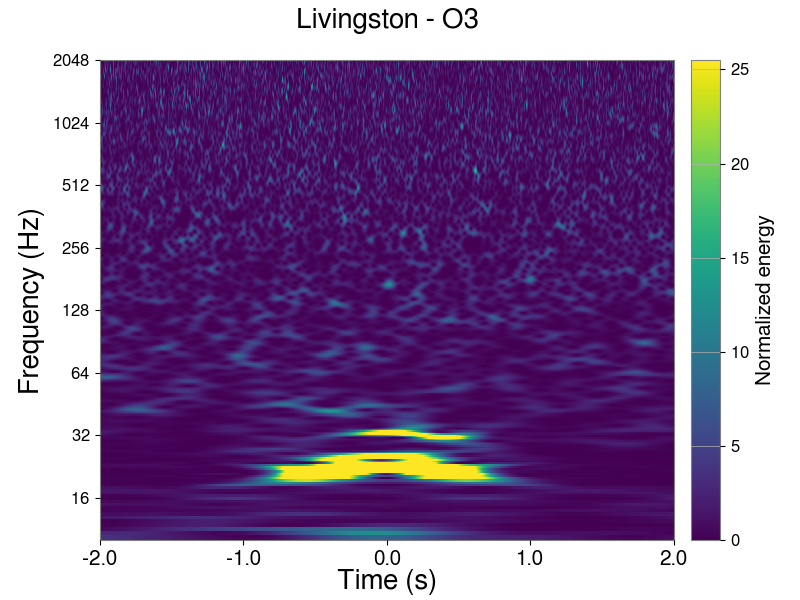

In [12]:
image, label = dataset[500]
print(label)
image

### This is Fast Scatter glitch

0


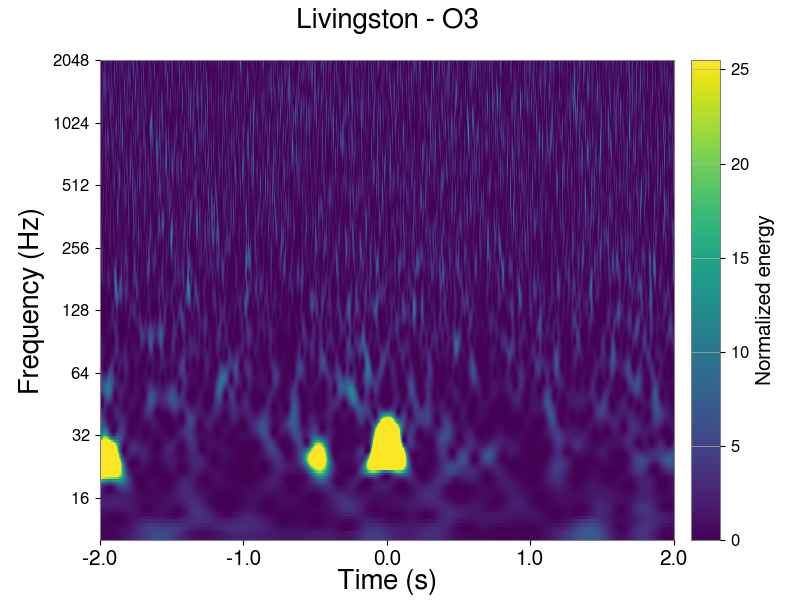

In [13]:
image, label = dataset[100]
print(label)
image

### This is Koi Fish glitch

1


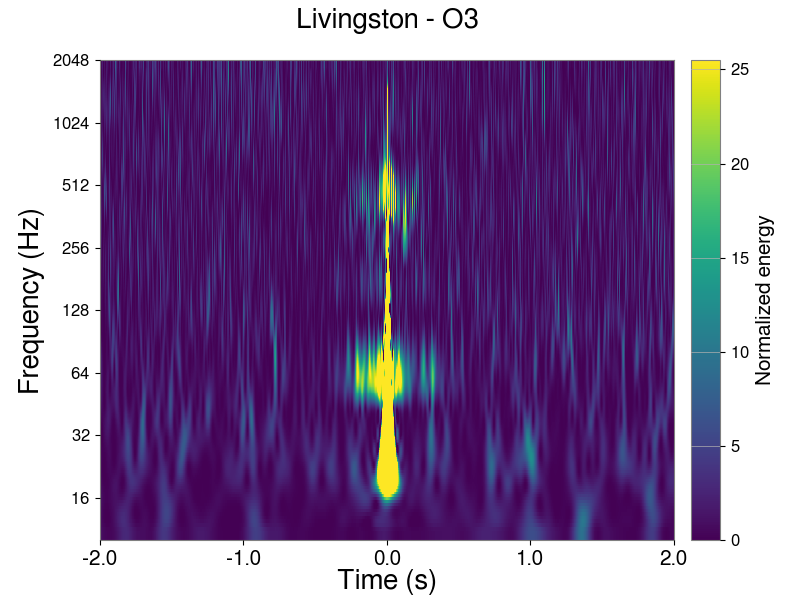

In [14]:
image, label = dataset[320]
print(label)
image

In [15]:
# Get a dictionary associating target values with folder names
data_dir = '/Users/siddharth/Desktop/github_projects/slow_fast_koi/Training/'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'Fast', 1: 'Koi', 2: 'Slow'}


In [16]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '/Users/siddharth/Desktop/github_projects/slow_fast_koi/Training/'
dataset = PlayingCardDataset(data_dir, transform)

In [17]:
image, label = dataset[510]
image.shape

torch.Size([3, 128, 128])

In [18]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [19]:
dataloader.batch_size

32

In [20]:
for images, labels in dataloader:
    break

In [21]:
images.shape

torch.Size([32, 3, 128, 128])

In [22]:
labels, len(labels)

(tensor([2, 2, 0, 2, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 2, 2, 0, 0, 2, 1, 0, 1, 1, 2,
         2, 1, 2, 2, 2, 1, 2, 2]),
 32)

### Creating the model

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pickle

# Define the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First Conv layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        nn.init.kaiming_normal_(self.conv1.weight)
        
        # Second Conv layer
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third Conv layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # # Fourth Conv layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # Adjust dimensions if necessary
        #self.fc1 = nn.Linear(36992,512)  # Adjust dimensions if necessary
        self.fc2 = nn.Linear(512,3)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = torch.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        #print(x.shape)
        return x

# Create the model
model = CNNModel()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

# Prepare the training and validation datasets
train_dir = '/Users/siddharth/Desktop/github_projects/slow_fast_koi/Training/'
valid_dir = '/Users/siddharth/Desktop/github_projects/slow_fast_koi/Validation/'

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
   transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)

valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=30, shuffle=False)

# Early stopping callback-like behavior
class EarlyStopping:
    def __init__(self, patience=9, threshold=0.95):
        self.patience = patience
        self.threshold = threshold
        self.best_acc = 0
        self.counter = 0

    def should_stop(self, acc):
        if acc > self.best_acc:
            self.best_acc = acc
            self.counter = 0
        else:
            self.counter += 1
        return acc >= self.threshold or self.counter >= self.patience

early_stopping = EarlyStopping(threshold=0.99)

# Training the model
def train(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            #print(_, predicted)
            #print(labels, predicted)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {train_acc}')

        # Validate the model
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_inputs, val_labels in valid_loader:
                val_outputs = model(val_inputs)
                _, val_predicted = val_outputs.max(1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)
        
        val_acc = val_correct / val_total
        print(f'Validation Accuracy: {val_acc}')

        # Check for early stopping
        if early_stopping.should_stop(val_acc):
            print("\nReached 99% accuracy or patience limit. Stopping training.")
            break

    return model

### We will now run the model 

In [24]:
# Train the model
model = train(model, train_loader, valid_loader, criterion, optimizer, epochs=10)

# Save the model
torch.save(model.state_dict(), '/Users/siddharth/Desktop/github_projects/slow_fast_koi/fast_slow_koi.h5')

# Save the training history
history = {
    'train_acc': early_stopping.best_acc,
    # You can add loss and val_loss if needed
}
with open('history.pkl', 'wb') as f:
    pickle.dump(history, f) 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 1/10, Loss: 0.8126394176483154, Accuracy: 0.7226666666666667
Validation Accuracy: 0.98
Epoch 2/10, Loss: 0.5755083632469177, Accuracy: 0.98
Validation Accuracy: 0.9933333333333333

Reached 99% accuracy or patience limit. Stopping training.


### Lets apply the model on some new images now in the Testing folder

In [25]:
# If using a GPU, move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

In [26]:
test_dataset = datasets.ImageFolder(root='Testing_images/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# Evaluate the model on the test dataset
def evaluate_test_data(model, loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Run evaluation on the test data
#evaluate_test_data(model, test_loader)

In [27]:
#test_loader.dataset.samples

In [28]:
evaluate_test_data(model, test_loader)

Test Accuracy: 97.96%


### ^^ This is the overall Testing accuracy

In [29]:
# Define the same transform used during training
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Use same normalization as training
])

# Function to load and preprocess a single image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Open the image and ensure it's RGB
    image = transform(image)  # Apply the transformations
    image = image.unsqueeze(0)  # Add batch dimension (1, C, H, W)
    return image


In [30]:
# Function to predict the class of a single image
def predict_image(image_path, model):
    image = preprocess_image(image_path)
    image = image.to(device)  # Move image to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)  # Get the index of the class with the highest score

    return predicted.item()  # Return the class index as an integer


In [31]:
import glob
fast_testing_images = glob.glob('Testing_images/Fast/'+'*.png')
slow_testing_images = glob.glob('Testing_images/Slow/'+'*.png')
koi_testing_images = glob.glob('Testing_images/Koi/'+'*.png')

In [32]:
koi_testing_images

['Testing_images/Koi/L1_1250217591.964349985_spectrogram_4.0.png',
 'Testing_images/Koi/L1_1252133617.511719942_spectrogram_4.0.png',
 'Testing_images/Koi/L1_1241120298.754879951_spectrogram_4.0.png',
 'Testing_images/Koi/L1_1261977024.310549974_spectrogram_4.0.png',
 'Testing_images/Koi/L1_1248783587.249510050_spectrogram_4.0.png',
 'Testing_images/Koi/L1_1244530747.600589991_spectrogram_4.0.png',
 'Testing_images/Koi/L1_1257916831.806639910_spectrogram_4.0.png',
 'Testing_images/Koi/L1_1246570635.649410009_spectrogram_4.0.png',
 'Testing_images/Koi/L1_1252575470.863280058_spectrogram_4.0.png']

In [33]:
from PIL import Image
image_path = [i for i in fast_testing_images]  # Replace with the path to your test image
for i in image_path:
    predicted_class = predict_image(i, model)
    #print(f'The predicted class index for the image is: {predicted_class}')
    # Get the mapping from class indices to class names
    class_names = train_dataset.classes  # Assuming `train_dataset` was defined during training
    print(f'The predicted class for the image is: {class_names[predicted_class]}')

The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predicted class for the image is: Fast
The predict

In [34]:
from PIL import Image
image_path = fast_testing_images[16]  # Replace with the path to your test image
predicted_class = predict_image(image_path, model)
#print(f'The predicted class index for the image is: {predicted_class}')
# Get the mapping from class indices to class names
class_names = train_dataset.classes  # Assuming `train_dataset` was defined during training
print(f'The predicted class for the image is: {class_names[predicted_class]}')

The predicted class for the image is: Fast
